# Load in Data

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import ttest_ind
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] =(26,12)

In [2]:
df = pd.read_csv('../data/raw/Customer_Dataset_File.csv')
df.replace('#NULL!', np.NaN, inplace=True)

# Create Modules to Use Throughout Process

In [3]:
#changes
# define module to create frequency distribution of variables
def freq_dist(df, col):
    df_fd = pd.DataFrame(data=df[col].value_counts())
    df_fd['pct_total'] = df_fd[col] / df_fd[col].sum()
    print(df_fd.head(15))
    
    
# define module to convert individual values in to buckets, creating corresponding labels; 
# outputs frequency distribution module above
def creat_bins(df, new_col, col, bins=[], labels=[]):
    df[new_col] = pd.cut(
    x=df[col], 
    bins=bins, 
    labels=labels)
    freq_dist(df, new_col)
    
    
#Module used to take a field in dollars seen as an 'object' and convert in to an Integer    
def convert_dollars(cols):
    df[cols] = df[cols].str.replace('#NULL!', '0.0')
    df[cols] = df[cols].str.replace(',', '')
    df[cols] = df[cols].str.replace('$', '')
    df[cols] = df[cols].str.replace(' ', '')
    df[cols] = df[cols].str.replace(')', '')
    df[cols] = df[cols].str.replace('-', '0.0')
    df[cols] = df[cols].str.replace('(', '-')
    df[cols] = df[cols].astype(float)
    df[cols] = df[cols].replace('.0', '')
    df[cols] = df[cols].astype(int)
    print('Converting', cols, 'Dollars to Numbers Complete')    
    
    
#Creates Histogram for Comparitive Purposes
def review_detail(df, equil, col, num, col2, num2, col3, meas, sub, type):    
    if type == 'total':
        df_last_month = df.loc[(df[col] != num) & (df[col2] != num2)]
        df_last_month = df_last_month.groupby(by=[col, col3, col2]).agg({'Total'+equil:meas})
        df_last_month.rename(columns = {'index':col3}, inplace=True)
        df_last_month['pct_total'] = ((df_last_month['Total'+equil] / df_last_month['Total'+equil].sum())*100).astype(int)
        df_last_month = pd.DataFrame(df_last_month)
        df_last_month = df_last_month.T
        print(df_last_month)
        df_last_month.drop_duplicates(inplace=True)
        df_last_month = df_last_month.T
        df_last_month.drop(columns=['pct_total'], inplace=True)


        df_last_month.unstack().plot(kind='bar', use_index=True, rot=0, 
                                     subplots=sub, title=(meas+' by '+col2))
    else:
        df_last_month = df.loc[(df[col] != num) & (df[col2] != num2)]
        df_last_month = df_last_month.groupby(by=[col, col3, col2]).agg({'Voice'+equil:meas, 
                                                                         'Equipment'+equil:meas, 
                                                                         'Data'+equil:meas})
        df_last_month.rename(columns = {'index':col3}, inplace=True)
        df_last_month = pd.DataFrame(df_last_month)
        print(df_last_month.head().T)

        df_last_month.unstack().plot(kind='bar', use_index=True, rot=0, 
                                     subplots=sub, title=(meas+' by '+col2))

# Examine Dataset: 

### Examine Shape (Rows and Columns)

In [4]:
rows = len(df)
columns = len(df.columns)
values = rows*columns
non_na = df.count().sum()
na = values-non_na

print('Number of rows:', rows, '\n')
print('Number of columns:', columns, '\n')

Number of rows: 5000 

Number of columns: 59 



### Review missing data cells

In [5]:
print('Total cells:', values, '\n')
print('Total values:', non_na, '\n')
print('Missing values:', na, '\n')

Total cells: 295000 

Total values: 294872 

Missing values: 128 



### Review Columns

In [6]:
print('Below is the current list of columns loaded: \n\n',
      df.columns, '\n\n **Removed the following columns before starting',
      'analysis: NumberPets, NumberCats, NumberDogs, NumberBirds.')

Below is the current list of columns loaded: 

 Index(['CustomerID', 'Region', 'TownSize', 'Gender', 'Age', 'EducationYears',
       'JobCategory', 'UnionMember', 'EmploymentLength', 'Retired', 'HHIncome',
       'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt', 'LoanDefault',
       'MaritalStatus', 'HouseholdSize', 'NumberPets', 'NumberCats',
       'NumberDogs', 'NumberBirds', 'HomeOwner', 'CarsOwned', 'CarOwnership',
       'CarBrand', 'CarValue', 'CommuteTime', 'PoliticalPartyMem', 'Votes',
       'CreditCard', 'CardTenure', 'CardItemsMonthly', 'CardSpendMonth',
       'ActiveLifestyle', 'PhoneCoTenure', 'VoiceLastMonth', 'VoiceOverTenure',
       'EquipmentRental', 'EquipmentLastMonth', 'EquipmentOverTenure',
       'CallingCard', 'WirelessData', 'DataLastMonth', 'DataOverTenure',
       'Multiline', 'VM', 'Pager', 'Internet', 'CallerID', 'CallWait',
       'CallForward', 'ThreeWayCalling', 'EBilling', 'TVWatchingHours',
       'OwnsPC', 'OwnsMobileDevice', 'OwnsGameSystem', 'OwnsF

In [7]:
df= df[['CustomerID','Region', 'TownSize', 'Gender', 'Age', 'EducationYears',
       'JobCategory', 'UnionMember', 'EmploymentLength', 'Retired', 'HHIncome',
       'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt', 'LoanDefault',
       'MaritalStatus', 'HouseholdSize', 'HomeOwner', 'CarsOwned', 'CarOwnership',
       'CarBrand', 'CarValue', 'CommuteTime', 'PoliticalPartyMem', 'Votes', 
        'CardTenure', 'CardItemsMonthly', 'CardSpendMonth',
       'ActiveLifestyle', 'PhoneCoTenure', 'VoiceLastMonth', 'VoiceOverTenure',
       'EquipmentRental', 'EquipmentLastMonth', 'EquipmentOverTenure',
       'CallingCard', 'WirelessData', 'DataLastMonth', 'DataOverTenure',
       'Multiline', 'VM', 'Pager', 'Internet', 'CallerID', 'CallWait',
       'CallForward', 'ThreeWayCalling', 'EBilling', 'TVWatchingHours',
       'OwnsPC', 'OwnsMobileDevice', 'OwnsGameSystem', 'OwnsFax',
       'NewsSubscriber']]

In [8]:
print('Below is a list of columns that have missing values:')
#Highlight what columns have missing values
[col for col in df.columns if df[col].isnull().any()]

Below is a list of columns that have missing values:


['TownSize',
 'Gender',
 'JobCategory',
 'HouseholdSize',
 'HomeOwner',
 'CommuteTime']

# Fill missing value cells with guestimations

In [9]:
# Replacing missing values with means: TownSize
df['TownSize'] = pd.to_numeric(df['TownSize'], errors='coerce')
df.TownSize.fillna(df.TownSize.mean(), inplace=True)
df['TownSize'] = df['TownSize'].astype(int)
freq_dist(df, 'TownSize')

   TownSize  pct_total
1      1436     0.2872
2      1050     0.2100
3       907     0.1814
4       857     0.1714
5       750     0.1500


In [10]:
# Recoding the missing values of Gender to Female
# Convert all missing values for gender to female - 
# arbitrary decision


df['Gender'] = df.Gender.replace(np.NaN,
                                 'Female')


freq_dist(df,'Gender')

        Gender  pct_total
Female    2527     0.5054
Male      2473     0.4946


In [11]:
# Replacing missing values with means: HouseholdSize
df.HouseholdSize.fillna(df.HouseholdSize.mean(), 
                        inplace=True)
df['HouseholdSize'] = df['HouseholdSize'].astype(int)
freq_dist(df, 'HouseholdSize')

   HouseholdSize  pct_total
1           2032     0.4064
2           1474     0.2948
3            552     0.1104
4            520     0.1040
5            287     0.0574
6             97     0.0194
7             29     0.0058
8              7     0.0014
9              2     0.0004


In [12]:
#Replacing missing values with 'Other': JobCategory+

df['JobCategory'] = df.JobCategory.replace(np.NaN,
                                 'Other')


freq_dist(df,'JobCategory')

              JobCategory  pct_total
Sales                1635     0.3270
Professional         1380     0.2760
Labor                 686     0.1372
Service               620     0.1240
Crafts                452     0.0904
Agriculture           212     0.0424
Other                  15     0.0030


In [13]:
#Replacing missing values with means: HomeOwner
df.HomeOwner.fillna(df.HomeOwner.mean(), inplace=True)
df['HomeOwner'] = df['HomeOwner'].astype(int)
freq_dist(df, 'HomeOwner')

   HomeOwner  pct_total
1       3140      0.628
0       1860      0.372


In [14]:
#Replacing missing values with means: HouseholdSize
df['CommuteTime'] = pd.to_numeric(df['CommuteTime'], errors='coerce')
df.CommuteTime.fillna(df.CommuteTime.mean(), inplace=True)
df['CommuteTime'] = df['CommuteTime'].astype(int)
freq_dist(df, 'CommuteTime')

    CommuteTime  pct_total
24          336     0.0672
23          335     0.0670
25          332     0.0664
27          331     0.0662
22          325     0.0650
26          311     0.0622
21          307     0.0614
28          293     0.0586
29          260     0.0520
30          226     0.0452
20          215     0.0430
19          209     0.0418
31          204     0.0408
18          171     0.0342
32          162     0.0324


## Convert Dollar Values to Numbers for Future Calculations

In [15]:
convert_dollars('HHIncome')
convert_dollars('CarValue')
convert_dollars('CardSpendMonth')
convert_dollars('VoiceLastMonth')
convert_dollars('VoiceOverTenure')
convert_dollars('EquipmentLastMonth')
convert_dollars('EquipmentOverTenure')
convert_dollars('DataOverTenure')
convert_dollars('DataLastMonth')

Converting HHIncome Dollars to Numbers Complete
Converting CarValue Dollars to Numbers Complete
Converting CardSpendMonth Dollars to Numbers Complete
Converting VoiceLastMonth Dollars to Numbers Complete
Converting VoiceOverTenure Dollars to Numbers Complete
Converting EquipmentLastMonth Dollars to Numbers Complete
Converting EquipmentOverTenure Dollars to Numbers Complete
Converting DataOverTenure Dollars to Numbers Complete
Converting DataLastMonth Dollars to Numbers Complete


In [16]:
#Highlight what columns have missing values after the above has been completed
print('Below is a list of Columns with missing values.  There should be no columns listed between the brackets.')
[col for col in df.columns if df[col].isnull().any()]

Below is a list of Columns with missing values.  There should be no columns listed between the brackets.


[]

# Convert Continuous Variables in to Discrete Variables

## Range Columns Key:

    
### Age Ranges:
    - Under 18 = 1
    - 18 thru 23 = 2
    - 24 thru 30 = 3
    - 31 thru 40 = 4
    - 41 thru 60 = 5
    - 61 and olver = 6
    
### HHIncome Ranges:
    - 0 thru 10,000 = 0
    - 10,001 thru 30,000 = 1
    - 30,001 thru 50,000 = 2
    - 50,001 thru 100,000 = 3
    - 100,001 thru 200,000 = 4
    - 200,001 thru 500,000 = 5
    - Over 500,000 = 6

### DebttoIncome Ranges:
    - 0 thru 1 = 1
    - 1 thru 1.3 = 2
    - 2 thru 5 = 3
    - 5.01 thru 10 = 4
    - 10.01 thru 20 = 5
    - 20.01 thru 50 = 6
    - Over 50 = 7

### Total Debt Ranges:
    - 0 thru 1,000 - 0
    - 1,001 thru 3,000 = 1
    - 3,001 thru 5,000 = 2
    - 5,001 thru 10,000 = 3
    - 20,000 thru 50,000 = 4
    - Over 50,000 = 5

   ### Convert Age Ranges in to Bins

In [17]:
# Convert Age Ranges in to Bins
creat_bins(df,'AgeRanges', 
           'Age', 
           bins=[0, 18, 23, 30, 40, 60, 1000], 
           labels=[0, 1, 2, 3, 4, 5])

   AgeRanges  pct_total
4       1588     0.3176
5       1386     0.2772
3        867     0.1734
2        634     0.1268
1        419     0.0838
0        106     0.0212


In [18]:
df['Internet'].replace(['2', '3', '4'], 
                       ['Yes', 'Yes', 'Yes'], 
                       inplace=True)
freq_dist(df, 'Internet')

     Internet  pct_total
Yes      2502     0.5004
No       2498     0.4996


# Review Aspects of Dataset and Group Relevant Columns

   ### Create 3 Total Columns adding Voice,Equipment,Data by:
    - OverTenure
    - LastMonth

In [19]:
# Create a TotalLastMonth Column adding Voice,Equipment,Data by
df['TotalLastMonth'] = df['VoiceLastMonth'] + df['EquipmentLastMonth'] + df['DataLastMonth']
df['TotalOverTenure'] = df['VoiceOverTenure']+df['EquipmentOverTenure']+df['DataOverTenure']

   ### Set a Monthly Average Column for Customers using Total Columns above
    - Divide Tenure Values by PhoneCoTenure (which is in months)
        -VoicePerMonth
        -DataPerMonth
        -EquipmentPerMonth
        -TotalPerMonth

In [20]:
# Create 'Total' column when grouping all data in to 1 aggregate
df['VoicePerMonth'] = df['VoiceOverTenure'] / df['PhoneCoTenure']
df['EquipmentPerMonth'] = df['EquipmentOverTenure'] / df['PhoneCoTenure']
df['DataPerMonth'] = df['DataOverTenure'] / df['PhoneCoTenure']
df['TotalPerMonth'] = df['TotalOverTenure'] / df['PhoneCoTenure']

 ### Create 'Total' column when grouping all data in to 1 aggregate 

In [21]:
df['Total'] = "Total"

   ### Convert PhoneCoTenure in to Years

In [22]:
# Convert PhoneCoTenure in to Years
creat_bins(df,'PhoneCoTenureYears', 
           'PhoneCoTenure', 
           bins=[0, 12, 24, 36, 48, 60, 1000], 
           labels=[0, 1, 2, 3, 4, 5])

   PhoneCoTenureYears  pct_total
5                1166   0.233340
0                 928   0.185711
2                 758   0.151691
4                 726   0.145287
1                 714   0.142886
3                 705   0.141085


   ### Create 'TotalDebt' column adding 'CreditDebt' and 'OtherDebt' 
   &
   ### Convert 'TotalDebt' in to Bins

In [23]:
# Create 'TotalDebt' column adding 'CreditDebt' and 'OtherDebt'
df['TotalDebt'] = df['CreditDebt']+df['OtherDebt']

# Convert Total Debt in to Bins
creat_bins(df,'TotalDebtRanges', 
           'TotalDebt', 
           bins=[0, 1,3,  5, 10, 20, 50, 2000], 
           labels=[0, 1, 2, 3, 4, 5, 6])

   TotalDebtRanges  pct_total
1             1649   0.329866
3             1005   0.201040
2              976   0.195239
0              684   0.136827
4              489   0.097820
5              179   0.035807
6               17   0.003401


   ### Convert 'HHIncome' in to Bins

In [24]:
# Convert HHIncome in to Bins
creat_bins(df,'HHIncomeRanges', 
           'HHIncome', 
           bins=[0, 10000,30000, 50000, 100000, 200000, 500000, 20000000], 
           labels=[0, 1, 2, 3, 4, 5, 6])

   HHIncomeRanges  pct_total
1            1752     0.3504
2            1275     0.2550
3            1254     0.2508
4             472     0.0944
0             138     0.0276
5             102     0.0204
6               7     0.0014


   ### Convert 'DebttoIncome' in to Bins

In [25]:
#Recode DebtToIncomeRatio_2 into a 7 level variable: DebtToIncomeRatio_2

df['DebtToIncomeRatio_2'] = df['DebtToIncomeRatio']*10

creat_bins(df,'DebtToIncomeRatio_rec', 
           'DebtToIncomeRatio_2', 
           bins=[-.5, 20, 40, 60, 80, 100, 130, 200, 1000000], 
           labels=[1, 2, 3, 4, 5, 6, 7, 8])

df.DebtToIncomeRatio_rec.replace(np.NaN,1, inplace=True)

df['DebtToIncomeRatio_rec'] = df['DebtToIncomeRatio_rec'].astype(int)

   DebtToIncomeRatio_rec  pct_total
7                    954     0.1908
6                    780     0.1560
3                    727     0.1454
4                    690     0.1380
5                    602     0.1204
2                    570     0.1140
8                    389     0.0778
1                    288     0.0576


### Create Category for Top and Bottom 50% of Customers

In [26]:
#Took top 2500 customers and categorized as top30
#Took bottom 2500 customer and categorized as bottom70
top_customers_df = df.sort_values(by='TotalPerMonth', ascending=False).head(2500)
top_customers_df['Top50_Bottom50'] = 'Top 50'
bottom_customers_df = df.sort_values(by='TotalPerMonth', ascending=False).tail(2500)
bottom_customers_df['Top50_Bottom50'] = 'Bottom 50'
df = top_customers_df.append(bottom_customers_df)
freq_dist(df, 'Top50_Bottom50')

           Top50_Bottom50  pct_total
Top 50               2500        0.5
Bottom 50            2500        0.5


# Get to know the data
## How many Customers have 0 sales last month?

In [27]:
print('\n', df.loc[df['TotalLastMonth']==0].shape[0], 'Customers had no sales last month. \n')


 0 Customers had no sales last month. 



### Confirmed all customers had some form of revnue generated last month.

### This confirms the data's intent is to measure:
    - Last month's sales
    - Total cumulative sales
    - PhoneCo Tenure (in months)

# Groupings (Before Analysis):

   ### Top and Bottom Customers
    - 'Top50_Bottom50'

   ### Geographic Location / Demographics
    - 'Region', 'TownSize', 'Gender', 'Age', , 'MaritalStatus, 'HouseholdSize'

   ### Customer Education/ Employment Details
    - 'EducationYears', 'JobCategory', 'UnionMember', 
    - 'EmploymentLength', 'Retired', 'HHIncome', 'CommuteTime',
    
   ### Customer Financial Details
    - 'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt', 'LoanDefault',
    - 'CardTenure', 'CardItemsMonthly', 'CardSpendMonth',
    - 'TotalDebt' = 'CreditDebt' + 'OtherDebt'
       **Removing Credit and Other Debt columns from dataset to replace with Total
       
   ### Customer LifeStyle:
       - 'TVWatchingHours','OwnsPC', 'OwnsMobileDevice','OwnsGameSystem', 'OwnsFax','NewsSubscriber'
      
    
   ### Customer Other Details
    - 'HomeOwner', 'CarsOwned', 'CarOwnership', 'CarBrand',
    -  'CarValue',  'PoliticalPartyMem', 'Votes', 'ActiveLifestyle'


   ### Customer Value:
   #### Total Spend:
       - Last Month's Sales: 'VoiceLastMonth', , 'DataLastMonth', 'EquipmentLastMonth'
       - Over Tenure Sales: 'VoiceOverTenure', 'EquipmentOverTenure', 'DataOverTenure'
       - Over Tenure Sales per Month: 'VoicePerMonth', 'EquipmentPerMonth', 'DataOverTenure'
           (***OverTenure values divided by PhoneCoTenure)
       - Added Last Month values together (Voice+Equipment+Data) to create 'Total' column
   
   #### Services Used:
       - 'EquipmentRental', 'CallingCard', 'WirelessData', 'Multiline', 
       - 'VM', 'Pager', , 'Internet', 'ThreeWayCalling', 'EBilling',
       - 'CallerID',  'CallWait', 'CallForward'
       -  'TotalServicesUsed' = Sum of all Above
       
   #### Customer Relationship:
       - 'PhoneCoTenure', 'PhoneCoTenureYears'
   
       
** Added a 'Total' column so that I can group the entire dataset as needed

# Analyze the top and bottom 50% best selling customers last month
    -There is a major difference in average sales per customer, as well as by line of business.

Top50_Bottom50 Bottom 50   Top 50
Total              Total    Total
Total              Total    Total
TotalLastMonth   28.9612  97.7248
pct_total        22.0000  77.0000


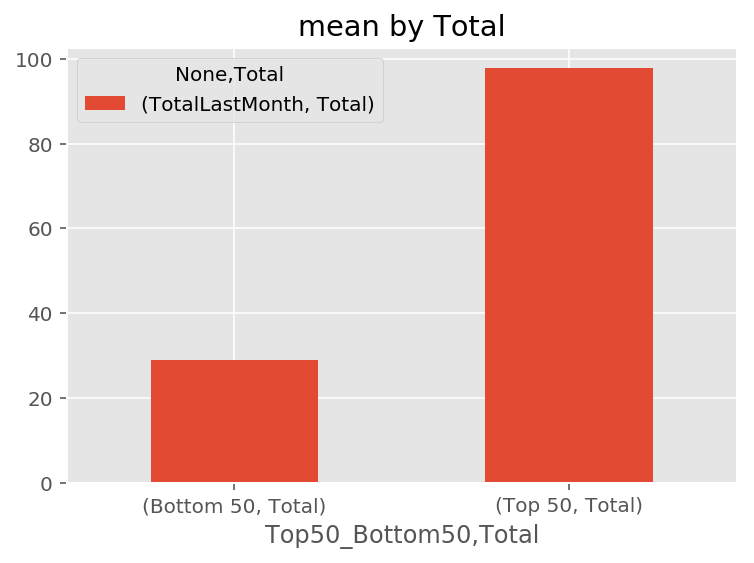

In [28]:
review_detail(df,'LastMonth',
              'Top50_Bottom50', "", 
              'Total', "", 
              'Total', 'mean', 
              False, 'total')

Top50_Bottom50     Bottom 50   Top 50
Total                  Total    Total
Total                  Total    Total
VoiceLastMonth       28.0140  51.8628
EquipmentLastMonth    0.5412  25.1264
DataLastMonth         0.4060  20.7356


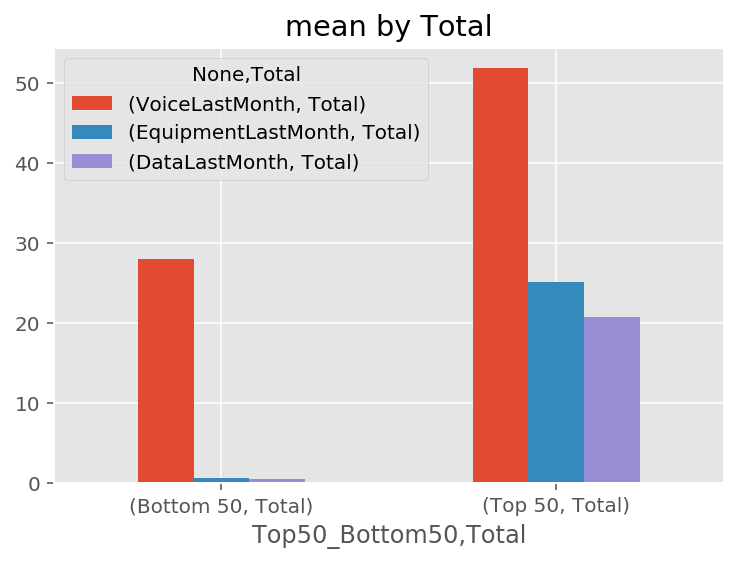

In [29]:
review_detail(df,'LastMonth',
              'Top50_Bottom50', "", 
              'Total', "", 
              'Total', 'mean', 
              False, 'else')

## Review Top and Bottom customers by Equipment Rental
    - Top Customers: 67% Rent Equipment
    - Bottom Customers: 1 % Rent Equipment

Top50_Bottom50  Top 50      
Total            Total      
EquipmentRental     No   Yes
TotalLastMonth     856  1644
pct_total           34    65


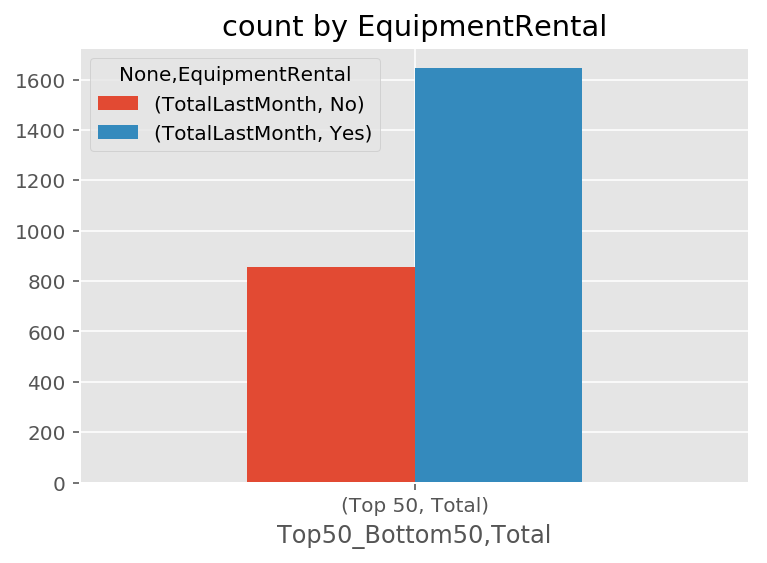

In [30]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Bottom 50    
Total               Total    
EquipmentRental        No Yes
TotalLastMonth       2440  60
pct_total              97   2


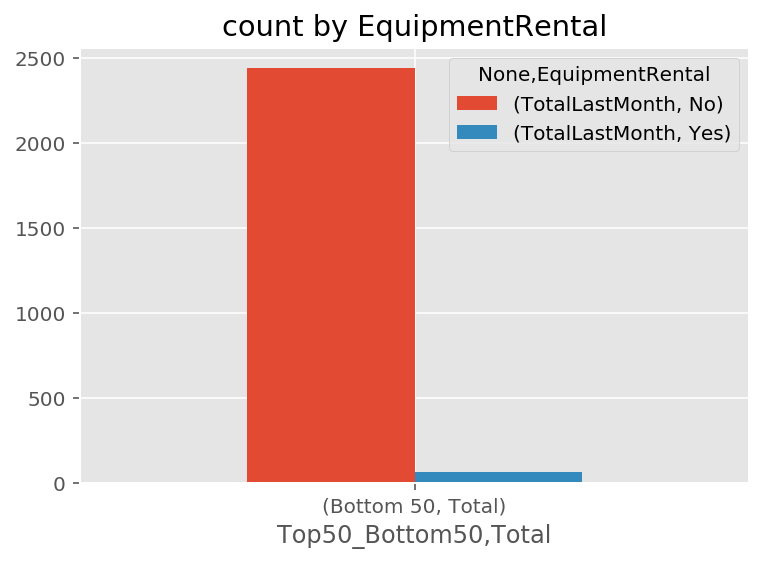

In [31]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'Total', 'count', 
              False, 'total')

## Review Top and Bottom customers by Age and Equipment Rental
    - There is a potential to improve equipment rental within all age groups in the bottom pool of customers
    - The age pattern for the top half of customers matches the 'Total' pool of customers

Total          Total                           
Total          Total                           
AgeRanges          0    1    2    3     4     5
TotalLastMonth   106  419  634  867  1588  1386
pct_total          2    8   12   17    31    27


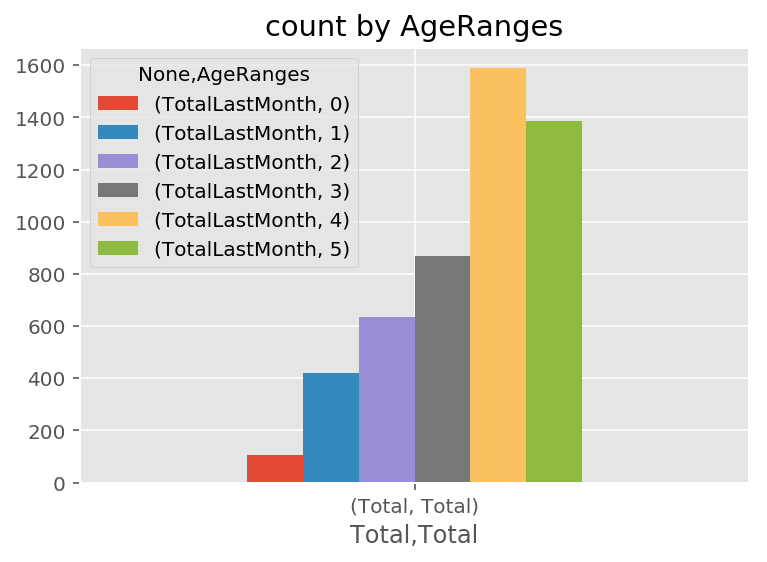

In [32]:
review_detail(df,'LastMonth',
              'Total', "", 
              'AgeRanges', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Top 50                                                   
AgeRanges            0       1        2        3         4         5     
EquipmentRental     No Yes  No  Yes  No  Yes  No  Yes   No  Yes   No  Yes
TotalLastMonth       7  21  26  147  33  282  90  336  286  527  414  331
pct_total            0   0   1    5   1   11   3   13   11   21   16   13


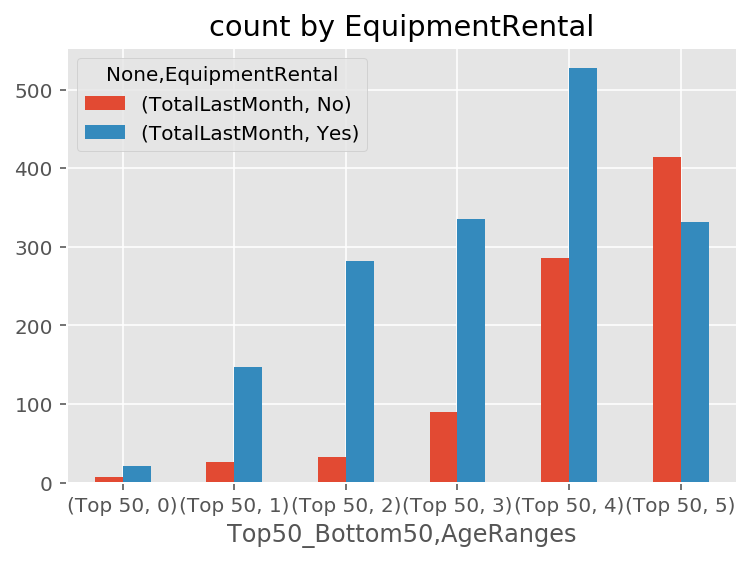

In [33]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'AgeRanges', 'count', 
              False, 'total')

Top50_Bottom50  Bottom 50                                                 
AgeRanges               0        1        2        3        4        5    
EquipmentRental        No Yes   No Yes   No Yes   No Yes   No Yes   No Yes
TotalLastMonth         72   6  232  14  307  12  429  12  761  14  639   2
pct_total               2   0    9   0   12   0   17   0   30   0   25   0


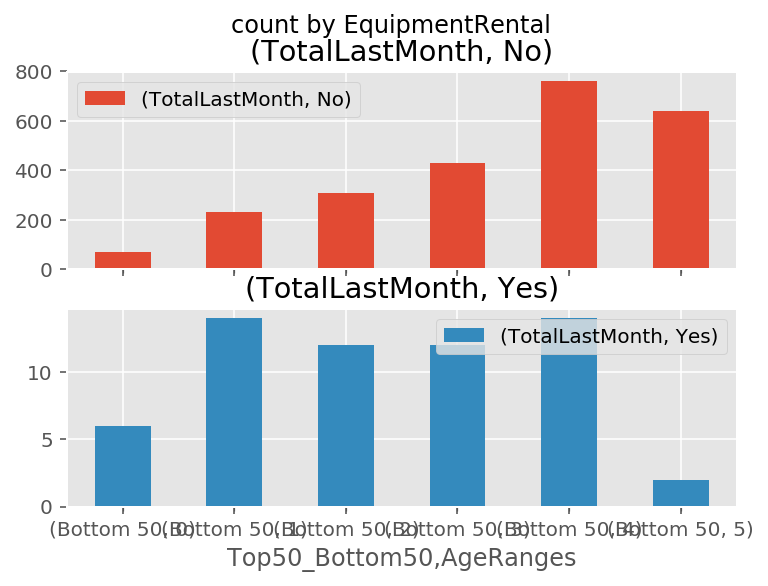

In [34]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'AgeRanges', 'count', 
              True, 'total')

## Review Top and Bottom customers by HHIncome and Equipment Rental
    - There is a potential to improve equipment rental within all ranges of HHIncome in the bottom pool of customers
    - The potential bottom customers match the same pattern as the top customers and total pool

Total          Total                                    
HHIncomeRanges     0     1     2     3     4     5     6
Total          Total Total Total Total Total Total Total
TotalLastMonth   138  1752  1275  1254   472   102     7
pct_total          2    35    25    25     9     2     0


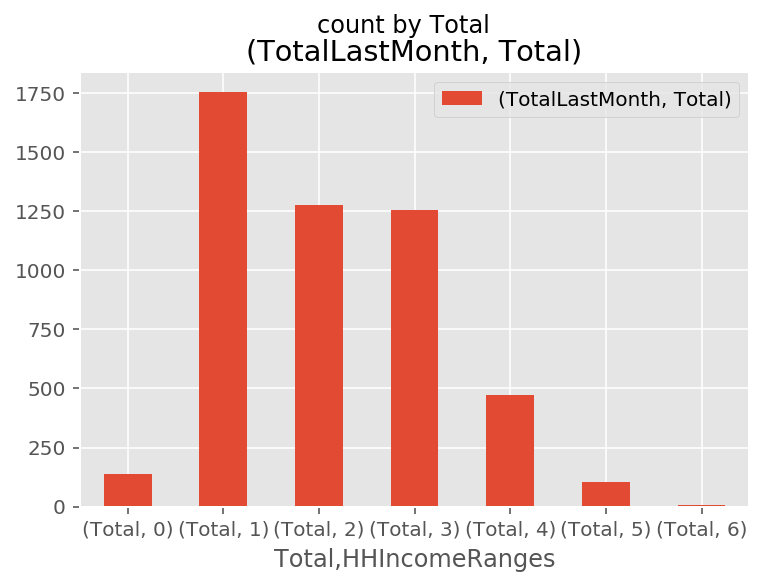

In [35]:
review_detail(df,'LastMonth',
              'Total', "", 
              'Total', "", 
              'HHIncomeRanges', 'count', 
              True, 'total')

Top50_Bottom50 Top 50                                                         
HHIncomeRanges      0        1        2         3        4        5      6    
OwnsPC             No Yes   No  Yes  No  Yes   No  Yes  No  Yes  No Yes No Yes
TotalLastMonth     14  36  116  634  93  499  131  553  70  265  20  62  1   6
pct_total           0   1    4   25   3   19    5   22   2   10   0   2  0   0


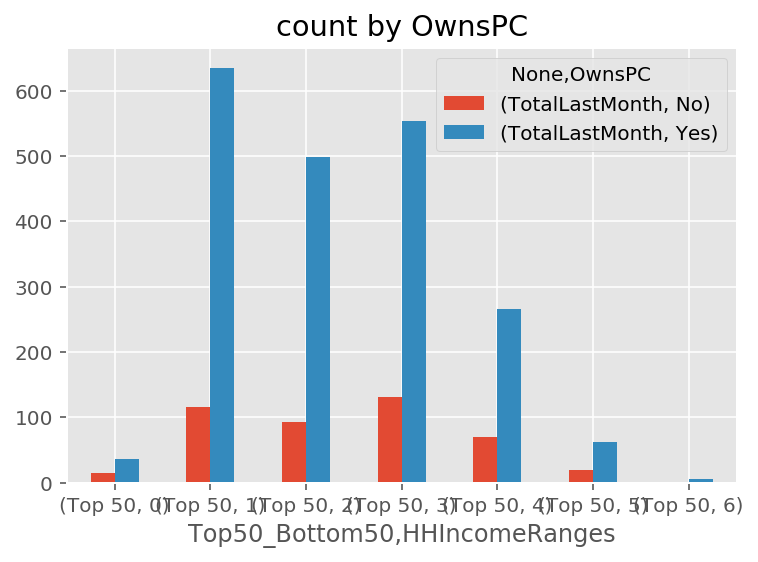

In [36]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'OwnsPC', "", 
              'HHIncomeRanges', 'count', 
              False, 'total')

Top50_Bottom50 Bottom 50                                                  
HHIncomeRanges         0        1         2         3        4       5    
OwnsPC                No Yes   No  Yes   No  Yes   No  Yes  No Yes  No Yes
TotalLastMonth        49  39  557  445  382  301  312  258  79  58  12   8
pct_total              1   1   22   17   15   12   12   10   3   2   0   0


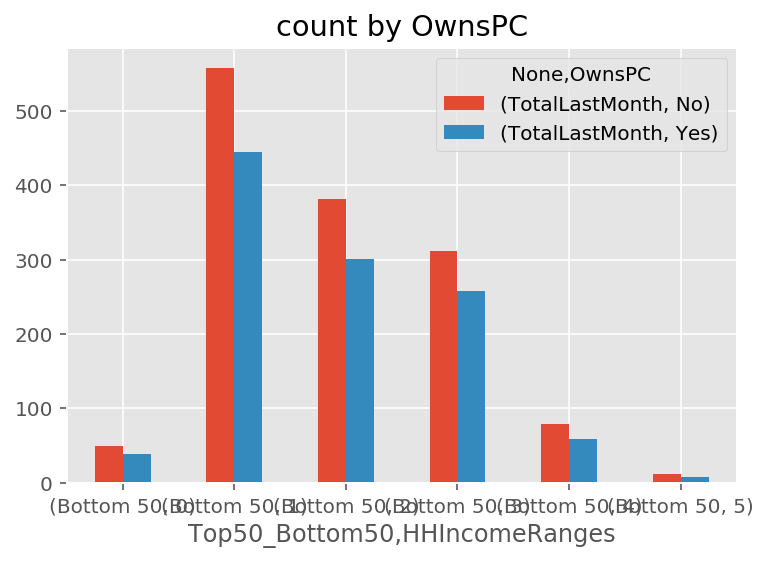

In [37]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'OwnsPC', "", 
              'HHIncomeRanges', 'count', 
              False, 'total')

## Review Top and Bottom customers by TotalDebt
    - There is a potential to improve equipment rental within all ranges of HHIncome in the bottom pool of customers
    - The potential bottom customers match the same pattern as the top customers and total pool

Total           Total                               
Total           Total                               
TotalDebtRanges     0     1    2     3    4    5   6
TotalLastMonth    684  1649  976  1005  489  179  17
pct_total          13    32   19    20    9    3   0


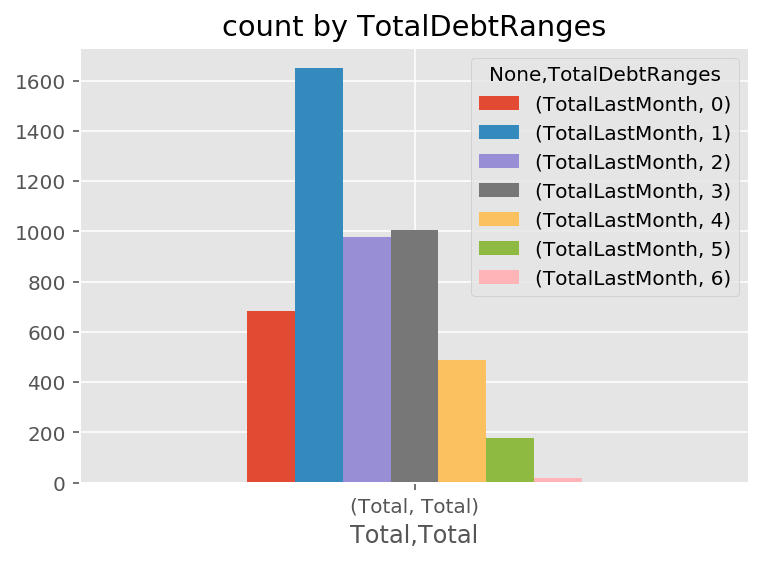

In [38]:
review_detail(df,'LastMonth',
              'Total', "", 
              'TotalDebtRanges', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Top 50                             
Total            Total                             
TotalDebtRanges      0    1    2    3    4    5   6
TotalLastMonth     290  763  469  536  293  133  15
pct_total           11   30   18   21   11    5   0


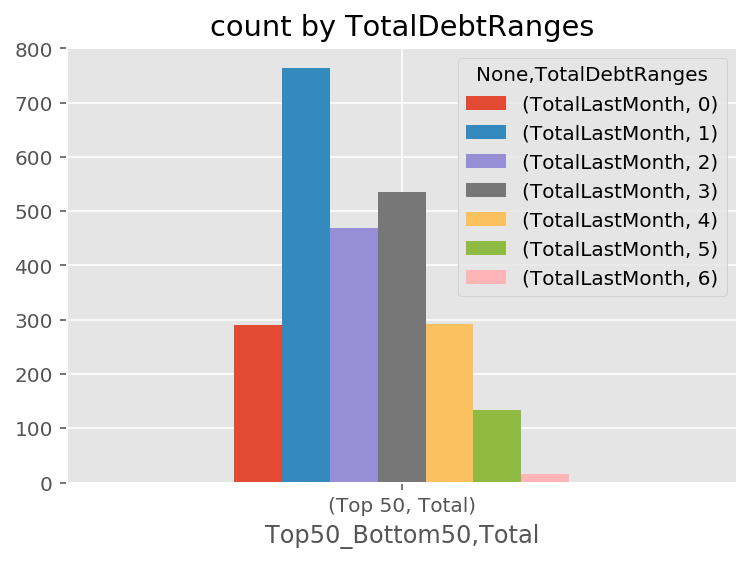

In [39]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'TotalDebtRanges', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Bottom 50                           
Total               Total                           
TotalDebtRanges         0    1    2    3    4   5  6
TotalLastMonth        394  886  507  469  196  46  2
pct_total              15   35   20   18    7   1  0


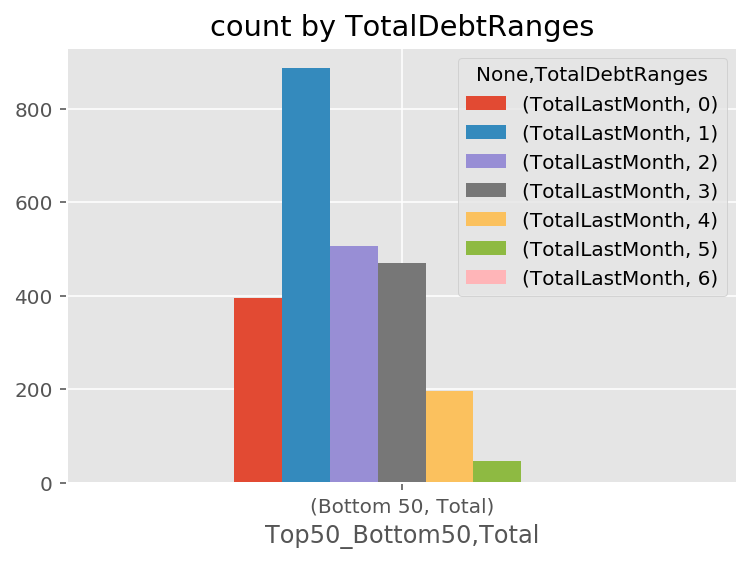

In [40]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'TotalDebtRanges', "", 
              'Total', 'count', 
              False, 'total')

## Do the Bottom Half of Customers Have Internet?

Total          Total      
Total          Total      
Internet          No   Yes
TotalLastMonth  2498  2502
pct_total         49    50


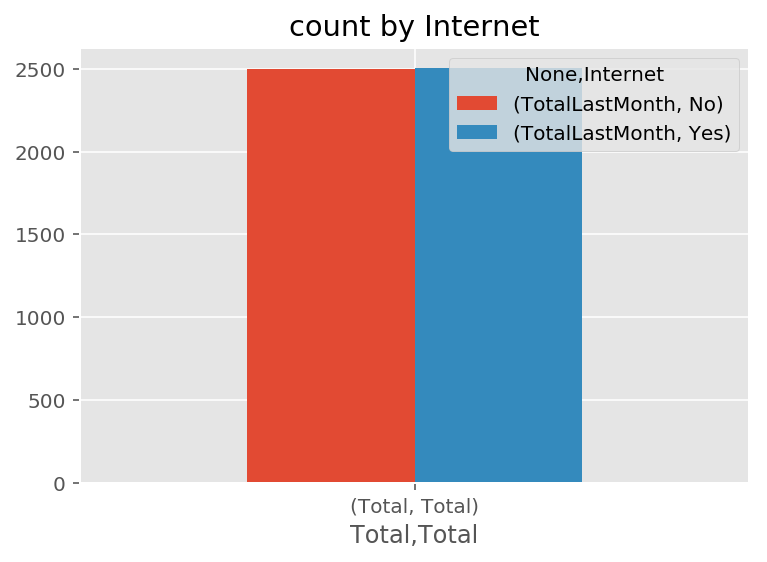

In [41]:
review_detail(df,'LastMonth',
              'Total', "", 
              'Internet', "", 
              'Total', 'count', 
              False, 'total')

## Review Top and Bottom customers by to assess who has Internet
    - There is an inverse relationship between top and bottom customers on who has Internet and who does not.
    - Top 74/26 split ; Bottom 26/74 split
    - Total is 50 / 50 split

Top50_Bottom50 Top 50      
Total           Total      
Internet           No   Yes
TotalLastMonth    696  1804
pct_total          27    72


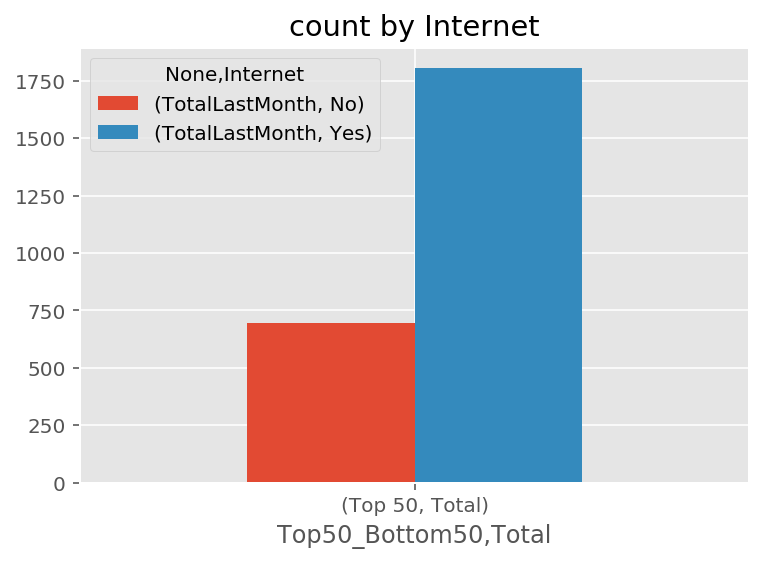

In [42]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Internet', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50 Bottom 50     
Total              Total     
Internet              No  Yes
TotalLastMonth      1802  698
pct_total             72   27


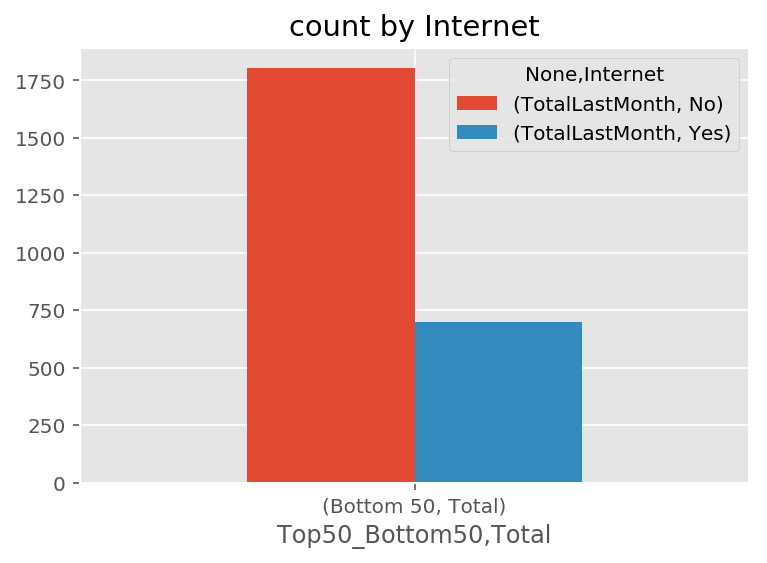

In [43]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Internet', "", 
              'Total', 'count', 
              False, 'total')

## Review Top and Bottom customers by to assess who has a Multiline Policy
    - There is an inverse relationship between top and bottom customers on who has Internet and who does not.
    - Top 60/40 split ; Bottom 40/60 split
    - Total is 49 / 51 split

Total          Total      
Total          Total      
Multiline         No   Yes
TotalLastMonth  2558  2442
pct_total         51    48


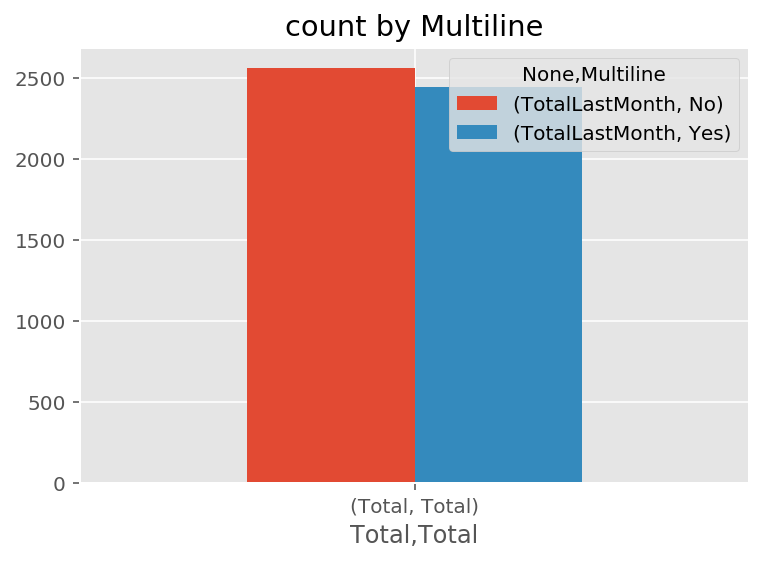

In [44]:
review_detail(df,'LastMonth',
              'Total', 1, 
              'Multiline', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50 Top 50      
Total           Total      
Multiline          No   Yes
TotalLastMonth    766  1734
pct_total          30    69


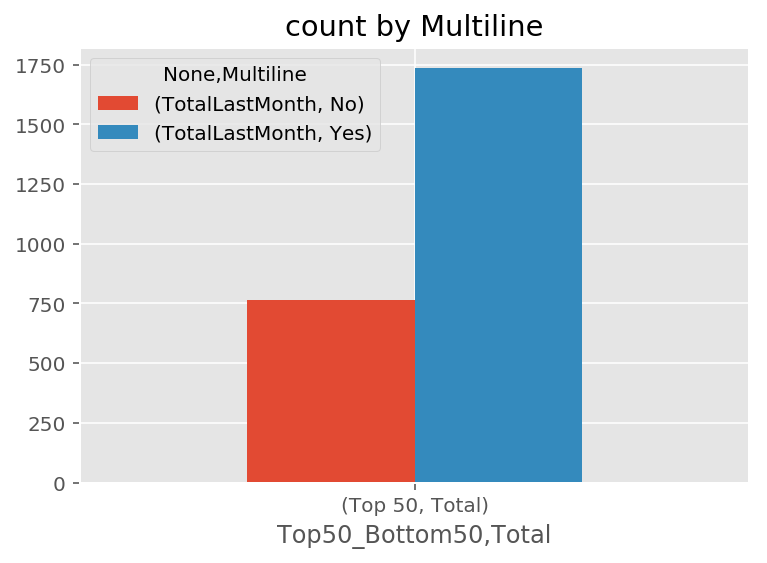

In [45]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Multiline', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50 Bottom 50     
Total              Total     
Multiline             No  Yes
TotalLastMonth      1792  708
pct_total             71   28


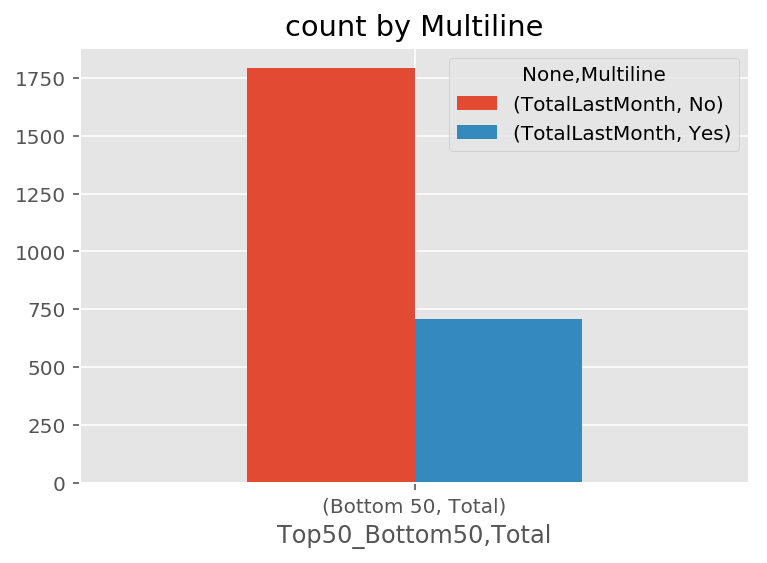

In [46]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Multiline', "", 
              'Total', 'count', 
              False, 'total')

## Review Total Customer Base for Customers who:
    - Do not rent equipment compared to who owns a PC
        - Rent Equipment - 95% Own a PC
        - Does not Rent - 46% Own a PC

EquipmentRental   Yes      
Total           Total      
OwnsPC             No   Yes
TotalLastMonth     87  1617
pct_total           5    94


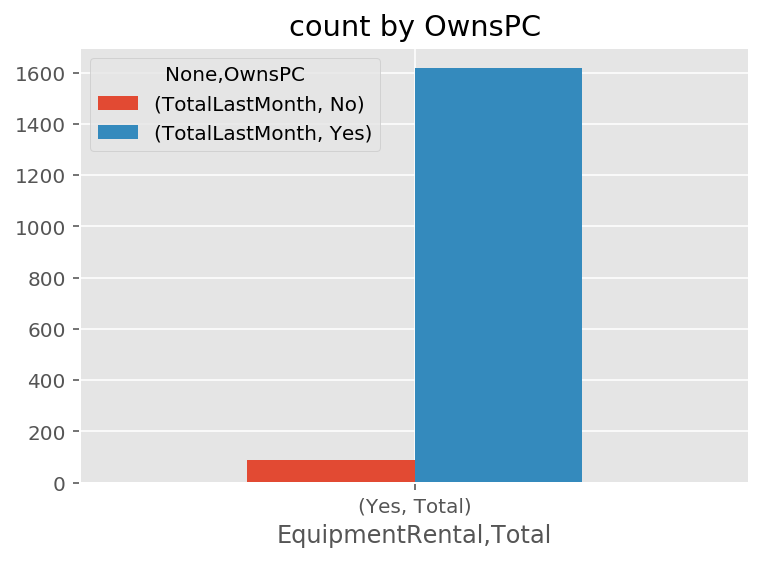

In [47]:
# Now assess Customers who rent equipment to see
# how many own as pc. 
# Results: 95% own a PC
review_detail(df,'LastMonth',
              'EquipmentRental', "No", 
              'OwnsPC', "", 
              'Total', 'count', 
              False, 'total')

EquipmentRental    No      
Total           Total      
OwnsPC             No   Yes
TotalLastMonth   1749  1547
pct_total          53    46


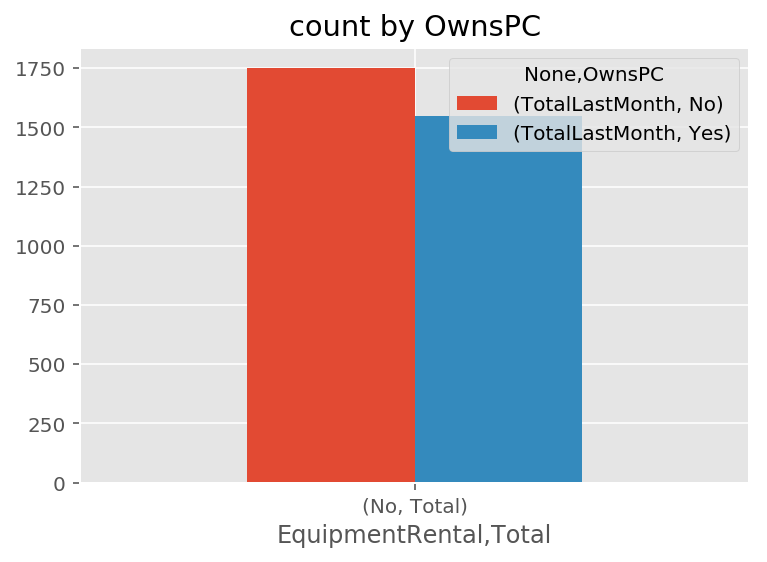

In [48]:
# Now assess Customers who rent equipment to see
# how many own as pc. 
# Results: 46% own a PC

review_detail(df,'LastMonth',
              'EquipmentRental', "Yes", 
              'OwnsPC', "", 
              'Total', 'count', 
              False, 'total')

In [49]:
df_multiline_no = df[df['Multiline']=='No']
df_multiline_yes = df[df['Multiline']=='Yes']

Total          Total                            
Total          Total                            
HHIncomeRanges     0     1    2    3    4   5  6
TotalLastMonth    57  1025  711  586  154  24  1
pct_total          2    40   27   22    6   0  0


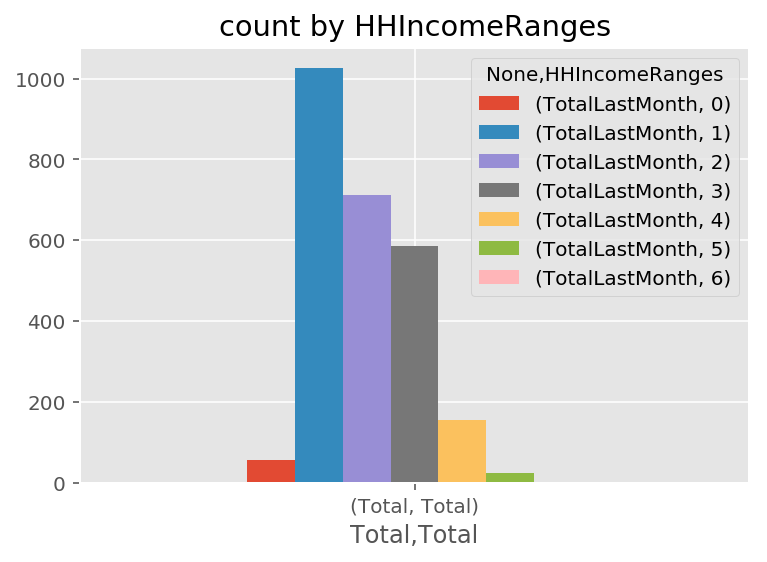

In [50]:
review_detail(df_multiline_no,'LastMonth',
              'Total', "No", 
              'HHIncomeRanges', "", 
              'Total', 'count', 
              False, 'total')

Total          Total                           
Total          Total                           
HHIncomeRanges     0    1    2    3    4   5  6
TotalLastMonth    81  727  564  668  318  78  6
pct_total          3   29   23   27   13   3  0


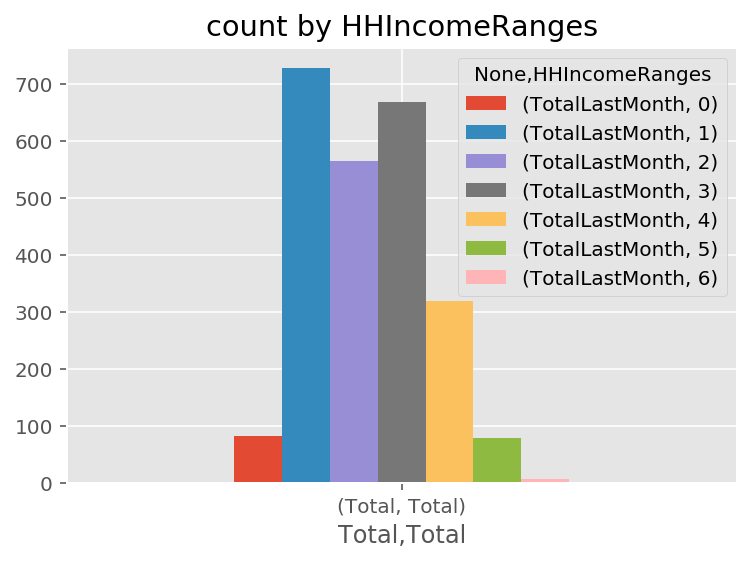

In [51]:
review_detail(df_multiline_yes,'LastMonth',
              'Total', "No", 
              'HHIncomeRanges', "", 
              'Total', 'count', 
              False, 'total')

# Next Steps: Convert Discrete Variables in to Numeric Values

## Created new dataframe: df_numeric = df

In [52]:
df_numeric = df

### Gender
    - Female = 0 ; Male - 1

In [53]:
df_numeric.Gender.replace(['Male', 'Female'] , 
                  [0, 1],
                 inplace=True)
freq_dist(df_numeric, 'Gender')

   Gender  pct_total
1    2527     0.5054
0    2473     0.4946


### Marital Status
    - Unmarried = 0 ; Married = 1

In [54]:
df_numeric.MaritalStatus.replace(['Unmarried', 
                                  'Married'], 
                                 [0, 1],
                                 inplace=True)
freq_dist(df_numeric,'MaritalStatus')

   MaritalStatus  pct_total
0           2599     0.5198
1           2401     0.4802


### CarBrand
    - Domestic = 0 ; Foreign = 1 ; -1 = 2

In [55]:
df_numeric.CarBrand.replace(['Domestic',
                             'Foreign','-1'], 
                            [0, 1, 2],
                            inplace=True)
freq_dist(df_numeric,'CarBrand')

   CarBrand  pct_total
0      2287     0.4574
1      2216     0.4432
2       497     0.0994


### CarOwnership
    - Own = 0 ; Lease = 1 ; -1 = 2

In [56]:
df_numeric.CarOwnership.replace(['Own', 
                                 'Lease', '-1'], 
                                [0, 1, 2],
                                inplace=True)
freq_dist(df_numeric,'CarOwnership')

   CarOwnership  pct_total
0          3704     0.7408
1           799     0.1598
2           497     0.0994


### Job Categories
    - Professional = 1
    - Sales = 2
    - Service = 3
    - Labor = 4
    - Agriculture = 5
    - Crafts = 6
    - Null = 7

In [57]:
# Replacing missing values with 'Other'
df_numeric['JobCategoryNo'] = df_numeric['JobCategory'].replace(['Professional', 
                           'Sales',
                          'Service',
                          'Labor',
                          'Agriculture',
                          'Crafts',
                          np.NaN], 
                          [1, 2, 3, 4,
                          5, 6, 7])

df_numeric['JobCategory'].fillna(value='Other', inplace=True)
freq_dist(df_numeric, 'JobCategory')

              JobCategory  pct_total
Sales                1635     0.3270
Professional         1380     0.2760
Labor                 686     0.1372
Service               620     0.1240
Crafts                452     0.0904
Agriculture           212     0.0424
Other                  15     0.0030


### All Others
    - Yes = 0 ; No = 1

In [58]:
#Convert columns with "Yes" and "No" values to 0 and 1, respectively

cols = ['UnionMember', 'Retired', 'LoanDefault',
       'PoliticalPartyMem', 'Votes', 'ActiveLifestyle', 'EquipmentRental',
       'CallingCard', 'WirelessData', 'Multiline', 'VM', 'Pager', 'CallerID',
       'CallWait', 'CallForward', 'ThreeWayCalling', 'EBilling', 'OwnsPC',
       'OwnsMobileDevice', 'OwnsGameSystem', 'OwnsFax', 'NewsSubscriber', 
        'Internet']


for ea in range(len(cols)):
    df_numeric[cols[ea]] = df_numeric[cols[ea]].replace(['Yes','No'], [0, 1])

### Top50_Bottom50:
    - Top 50% of Customers = 0
    - Bottom 50% of Customers = 1

### Create 'TotalServicesUsed' column by adding all 12 services provided by the business
    - 'CallingCard', 'WirelessData', 'Multiline','VM', 'CallForward', 'CallerID'
    - 'Pager', 'Internet', 'ThreeWayCalling', 'CallWait', 'EquipmentRental'

In [59]:
df['TotalServicesUsed'] =  (df['EquipmentRental'] + df['CallingCard'] + 
                                    df['WirelessData'] + df['Multiline'] + df['VM'] + 
                                    df['Pager'] + df['Internet'] + df['CallerID'] + 
                                    df['CallWait'] + df['CallForward'] + df['ThreeWayCalling'])

In [60]:
df_numeric.Top50_Bottom50.replace(['Top 50',
                                   'Bottom 50'], 
                                  [0, 1],
                                  inplace=True)
freq_dist(df_numeric,'Top50_Bottom50')

   Top50_Bottom50  pct_total
1            2500        0.5
0            2500        0.5


In [61]:
df_numeric['PhoneCoTenureYears'] = df_numeric.PhoneCoTenureYears.astype(int)
df_numeric['AgeRanges'] = df_numeric.AgeRanges.astype(int)
df_numeric['TotalDebtRanges'] = df_numeric.TotalDebtRanges.astype(int)
df_numeric['HHIncomeRanges'] = df_numeric.HHIncomeRanges.astype(int)
df_numeric['TotalPerMonth'] = df_numeric.TotalPerMonth.fillna(0).astype(int)

In [62]:
df_numeric = df[['CustomerID', 'PhoneCoTenure', 'EquipmentRental', 'TotalServicesUsed', 'TotalPerMonth',
                'TotalLastMonth', 'OwnsPC', 'HHIncome', 'Top50_Bottom50']]

### Review Columns Below for Missing Values

In [63]:
#Selecting only text columns to confirm above; There should be none other than 'CustomerID' before moving forward
text = ['object', 'category']
text_cols = df_numeric.select_dtypes(include= text)
print(text_cols.columns, '\n')
print(text_cols.shape)
text_cols.head(5).T

Index(['CustomerID'], dtype='object') 

(5000, 1)


,1064,1442,1957,3844,2070
CustomerID,7415-IIKLBO-8VO,4069-WOXDZW-2Y0,3421-JRQVBI-0GE,8199-MOWDXQ-I84,5996-NSVZTW-7VD


In [64]:
df_numeric.set_index('CustomerID', inplace=True)

In [65]:
df_numeric.to_csv('../data/modified/data_due_diligence_output.csv')

# Appendix: Groupings After Analysis

## Groupings (After Analysis):

   ### Top and Bottom Customers
    - 'Top50_Bottom50'

   ### Geographic Location / Demographics
    - 'Region', 'TownSize', 'Gender', 'AgeRanges', 'MaritalStatus, 'HouseholdSize'

   ### Customer Education/ Employment Details
    - 'EducationYears', 'JobCategory', 'UnionMember', 
    - 'EmploymentLength', 'Retired', 'HHIncome', 'CommuteTime',
    
   ### Customer Financial Details
    - 'DebtToIncomeRatio', 'TotalDebtRanges'*, 'LoanDefault',

       *Removing Credit and Other Debt columns from dataset to replace with Total
       
   ### Customer LifeStyle:
       - 'TVWatchingHours','OwnsPC', 'OwnsMobileDevice','OwnsGameSystem', 'OwnsFax','NewsSubscriber'
      
    
   ### Customer Other Details
    - 'HomeOwner', 'CarsOwned', 'CarOwnership', 'CarBrand',
    -  'CarValue',  'PoliticalPartyMem', 'Votes', 'ActiveLifestyle'


   ### Customer Value:
   
   #### Total Spend: 
       - 'TotalLastMonth', 'TotalPerMonth'
   
   #### Services Used:
       - 'EquipmentRental', 'CallingCard', 'WirelessData', 'Multiline', 
       - 'VM', 'Pager', , 'Internet', 'ThreeWayCalling', 'EBilling',
       - 'CallerID',  'CallWait', 'CallForward'
       -  'TotalServicesUsed' = Sum of all Above
       
   #### Customer Relationship:
       - 'PhoneCoTenure', 'PhoneCoTenureYears'
       
   ### Removing So Far: 
       - 'Age', 'UnionMember', 'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt'
       - 'CardTenure', 'CardItemsMonthly', 'CardSpendMonth', 'CarsOwned', 
       - 'CarOwnership', 'CarBrand', 'CarValue',  'PoliticalPartyMem', 'Votes'
       - 'JobCategoryNo', 'CardTenure', 'CardItemsMonthly', 'CardSpendMonth',
       - Last Month's Sales: 'VoiceLastMonth', , 'DataLastMonth', 'EquipmentLastMonth'
       - Over Tenure Sales: 'VoiceOverTenure', 'EquipmentOverTenure', 'DataOverTenure'
       - Over Tenure Sales per Month: 'VoicePerMonth', 'EquipmentPerMonth', 'DataOverTenure'
       
** Added a 'Total' column so that I can group the entire dataset as needed

In [66]:
# df_num = df[['Top50_Bottom50', 'TotalLastMonth', 'EducationYears', 'JobCategory', 'HouseholdSize', 
#              'ActiveLifestyle', 'EquipmentRental', 'OwnsPC', 'Internet', 'TotalServicesUsed',
#             'HHIncome', 'Gender']]